## Load the dataset 

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
df = pd.read_csv('starcraft_player_data.csv')

## EDA & ETL

#### Data cleaning

In [3]:
print(df.isnull().sum())
print(df.dtypes)
print(df['Age'].unique())
print(df['HoursPerWeek'].unique())
print(df['TotalHours'].unique())

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64
GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC       

In [4]:
# replace symbol with NaN
def replace_and_convert(df, symbol):
    cols_with_symbol = df.columns[df.isin([symbol]).any()]
    for col in cols_with_symbol:
        df[col] = df[col].replace(symbol, np.nan)
        df[col] = pd.to_numeric(df[col])
    return df

df = replace_and_convert(df, '?')

from sklearn.impute import KNNImputer
# KNN Imputation
def impute_with_knn(df, n_neighbors=3):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = imputer.fit_transform(df)
    df = pd.DataFrame(df_imputed, columns=df.columns) 
    return df

df = impute_with_knn(df)

df["LeagueIndex"] = pd.Categorical(df["LeagueIndex"], ordered=True)


#### Overall Description

count     3395.0
unique       8.0
top          4.0
freq       811.0
Name: LeagueIndex, dtype: float64
             GameID          Age  HoursPerWeek      TotalHours          APM  \
count   3395.000000  3395.000000   3395.000000     3395.000000  3395.000000   
mean    4805.012371    21.615808     16.146097      961.747079   117.046947   
std     2719.944851     4.180145     12.016897    17172.147403    51.945291   
min       52.000000    16.000000      0.000000        3.000000    22.059600   
25%     2464.500000    19.000000      8.000000      300.000000    79.900200   
50%     4874.000000    21.000000     12.000000      500.000000   108.010200   
75%     7108.500000    24.000000     20.000000      800.000000   142.790400   
max    10095.000000    44.000000    168.000000  1000000.000000   389.831400   

       SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  MinimapAttacks  \
count      3395.000000      3395.000000    3395.000000     3395.000000   
mean          0.004299         0.00037

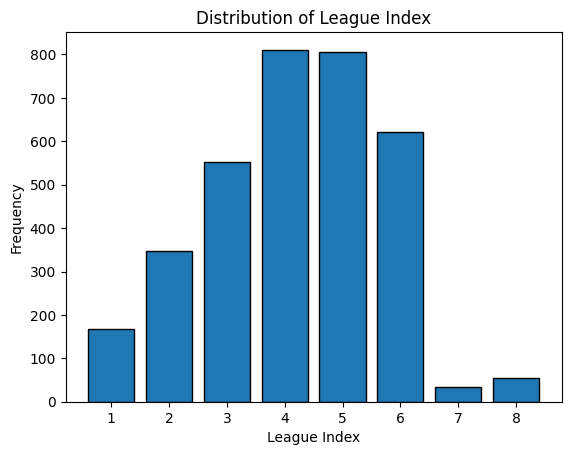

In [29]:
print(df["LeagueIndex"].describe())
print(df.describe())
import matplotlib.pyplot as plt
counts = df['LeagueIndex'].value_counts()
plt.bar(counts.index, counts.values, edgecolor='black')
plt.xlabel('League Index')
plt.ylabel('Frequency')
plt.title('Distribution of League Index')
plt.show()

**Data is imbalance.**

#### Further Analyze


<ipython-input-32-35840cf152b8>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr =(df.drop(columns='GameID')).corr()


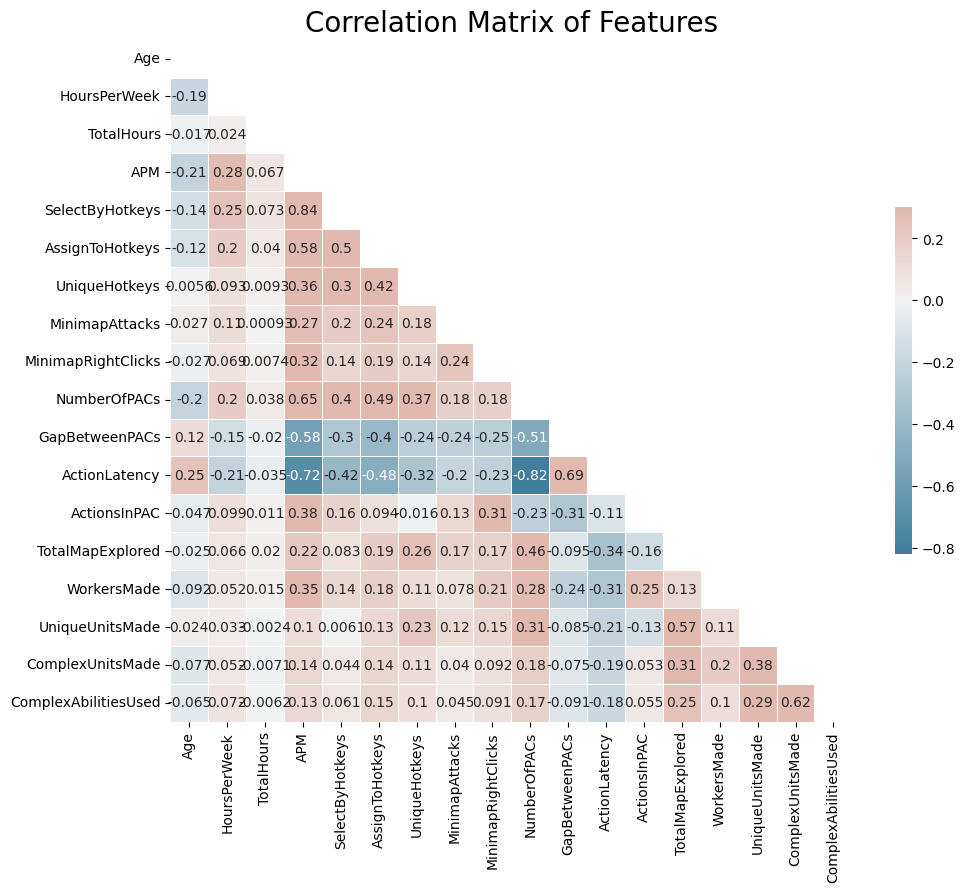

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
corr =(df.drop(columns='GameID')).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('Correlation Matrix of Features', fontsize=20)
plt.show()


## Modeling

#### Split data

In [41]:
features = df.drop(columns='LeagueIndex')
target = df['LeagueIndex']
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=99)
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size=0.2, random_state=99)


#### Desion Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(random_state=99)

param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'ccp_alpha': [0.0, 0.01, 0.1, 0.5, 1.0]
}


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(features_train, target_train)

print("Best Parameters:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
val_preds = best_model.predict(features_val)

# precision, recall, and F1 score on the validation set
val_precision = precision_score(target_val, val_preds, average='weighted')
val_recall = recall_score(target_val, val_preds, average='weighted')
val_f1 = f1_score(target_val, val_preds, average='weighted')

print(f'\nValidation Precision: {val_precision*100:.2f}%')
print(f'Validation Recall: {val_recall*100:.2f}%')
print(f'Validation F1: {val_f1*100:.2f}%')

# classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(target_val, val_preds))
print("\nConfusion Matrix:")
print(confusion_matrix(target_val, val_preds))

# Prune 
pruned_model = DecisionTreeClassifier(**grid_search.best_params_)
pruned_model.fit(features_train, target_train)

# Evaluation
test_preds = pruned_model.predict(features_test)

# precision, recall, and F1 score on the test set
test_precision = precision_score(target_test, test_preds, average='weighted')
test_recall = recall_score(target_test, test_preds, average='weighted')
test_f1 = f1_score(target_test, test_preds, average='weighted')

print(f'\nTest Precision: {test_precision*100:.2f}%')
print(f'Test Recall: {test_recall*100:.2f}%')
print(f'Test F1: {test_f1*100:.2f}%')

Best Parameters:
{'ccp_alpha': 0.0, 'max_depth': 5, 'min_samples_split': 5}

Validation Precision: 37.72%
Validation Recall: 37.32%
Validation F1: 34.60%

Classification Report:
              precision    recall  f1-score   support

         1.0       0.43      0.22      0.29        27
         2.0       0.23      0.53      0.32        49
         3.0       0.20      0.01      0.02        90
         4.0       0.32      0.55      0.40       117
         5.0       0.41      0.34      0.37       140
         6.0       0.56      0.45      0.50       106
         7.0       0.00      0.00      0.00         5
         8.0       1.00      1.00      1.00        10

    accuracy                           0.37       544
   macro avg       0.39      0.39      0.36       544
weighted avg       0.38      0.37      0.35       544


Confusion Matrix:
[[ 6 18  1  2  0  0  0  0]
 [ 6 26  2 14  1  0  0  0]
 [ 2 38  1 44  2  3  0  0]
 [ 0 20  1 64 26  6  0  0]
 [ 0  8  0 60 48 24  0  0]
 [ 0  2  0 16 40 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

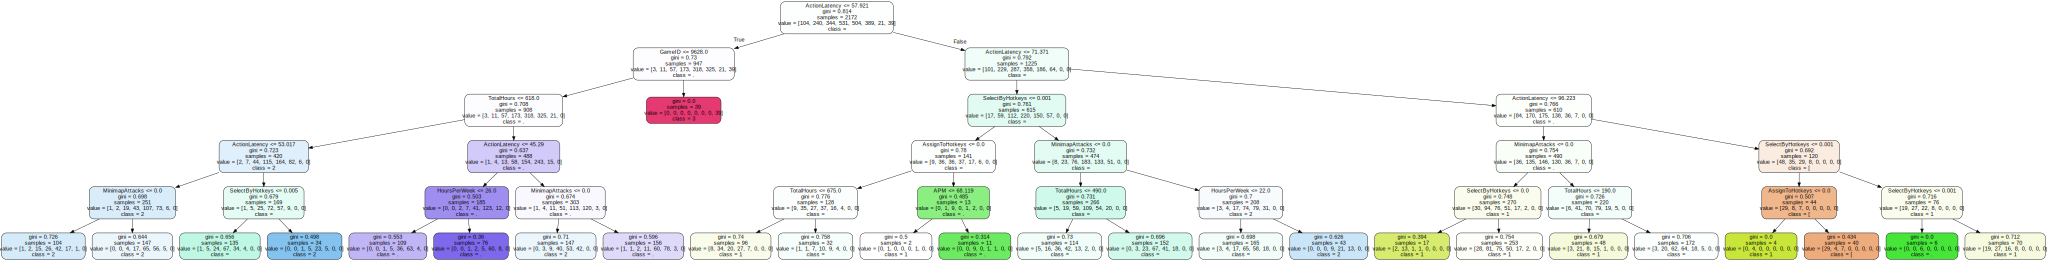

In [43]:
from sklearn.tree import export_graphviz
import graphviz

# export the tree to dot format
dot_data = export_graphviz(best_model, out_file=None, 
                           feature_names=features_train.columns, 
                           class_names=str(best_model.classes_), 
                           filled=True, 
                           rounded=True)

# use graphviz to create a graph from the dot data
graph = graphviz.Source(dot_data)

# show the graph
graph

In [44]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

nb_model = GaussianNB()
nb_model.fit(features_train, target_train)
predictions = nb_model.predict(features_val)

# precision, recall, and F1 score on the validation set
val_precision = precision_score(target_val, predictions, average='weighted')
val_recall = recall_score(target_val, predictions, average='weighted')
val_f1 = f1_score(target_val, predictions, average='weighted')

print(f'Validation Precision: {val_precision*100:.2f}%')
print(f'Validation Recall: {val_recall*100:.2f}%')
print(f'Validation F1: {val_f1*100:.2f}%')

# classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(target_val, predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(target_val, predictions))

# optimize model parameters
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5)
grid_search.fit(features_train, target_train)

# the best parameters
print("\nBest Parameters:")
print(grid_search.best_params_)
best_model = grid_search.best_estimator_
test_preds = best_model.predict(features_test)

# precision, recall, and F1 score on the test set
test_precision = precision_score(target_test, test_preds, average='weighted')
test_recall = recall_score(target_test, test_preds, average='weighted')
test_f1 = f1_score(target_test, test_preds, average='weighted')

print(f'\nTest Precision: {test_precision*100:.2f}%')
print(f'Test Recall: {test_recall*100:.2f}%')
print(f'Test F1: {test_f1*100:.2f}%')


Validation Precision: 38.73%
Validation Recall: 37.68%
Validation F1: 36.94%

Classification Report:
              precision    recall  f1-score   support

         1.0       0.50      0.52      0.51        27
         2.0       0.25      0.47      0.32        49
         3.0       0.28      0.10      0.15        90
         4.0       0.31      0.41      0.35       117
         5.0       0.38      0.36      0.37       140
         6.0       0.57      0.48      0.52       106
         7.0       0.00      0.00      0.00         5
         8.0       1.00      1.00      1.00        10

    accuracy                           0.38       544
   macro avg       0.41      0.42      0.40       544
weighted avg       0.39      0.38      0.37       544


Confusion Matrix:
[[14  9  3  1  0  0  0  0]
 [11 23  3 11  1  0  0  0]
 [ 3 39  9 30  5  4  0  0]
 [ 0 20  7 48 36  6  0  0]
 [ 0  2  9 55 50 23  1  0]
 [ 0  0  1 11 40 51  3  0]
 [ 0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  0 10]]

Best Parame

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

model = RandomForestClassifier(random_state=99)
model.fit(features_train, target_train)
val_preds = model.predict(features_val)

# precision, recall, and F1 score on the validation set
val_precision = precision_score(target_val, val_preds, average='weighted')
val_recall = recall_score(target_val, val_preds, average='weighted')
val_f1 = f1_score(target_val, val_preds, average='weighted')

print(f'Validation Precision: {val_precision*100:.2f}%')
print(f'Validation Recall: {val_recall*100:.2f}%')
print(f'Validation F1: {val_f1*100:.2f}%')

# classification report and confusion matrix for the validation set
print("\nClassification Report (Validation Set):")
print(classification_report(target_val, val_preds))
print("\nConfusion Matrix (Validation Set):")
print(confusion_matrix(target_val, val_preds))

# optimize model parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(features_val, target_val)

print("\nBest Parameters:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.fit(features_train, target_train)

test_preds = best_model.predict(features_test)

# precision, recall, and F1 score on the test set
test_precision = precision_score(target_test, test_preds, average='weighted')
test_recall = recall_score(target_test, test_preds, average='weighted')
test_f1 = f1_score(target_test, test_preds, average='weighted')

print(f'\nTest Precision: {test_precision*100:.2f}%')
print(f'Test Recall: {test_recall*100:.2f}%')
print(f'Test F1: {test_f1*100:.2f}%')

# classification report and confusion matrix for the test set
print("\nClassification Report (Test Set):")
print(classification_report(target_test, test_preds))
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(target_test, test_preds))



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Validation Precision: 40.00%
Validation Recall: 39.91%
Validation F1: 39.57%

Classification Report (Validation Set):
              precision    recall  f1-score   support

         1.0       0.48      0.33      0.39        36
         2.0       0.30      0.31      0.30        58
         3.0       0.36      0.27      0.31       119
         4.0       0.37      0.46      0.41       163
         5.0       0.38      0.43      0.40       162
         6.0       0.54      0.47      0.50       126
         7.0       0.00      0.00      0.00         9
         8.0       1.00      1.00      1.00         6

    accuracy                           0.40       679
   macro avg       0.43      0.41      0.41       679
weighted avg       0.40      0.40      0.40       679


Confusion Matrix (Validation Set):
[[12 12  7  5  0  0  0  0]
 [ 7 18 13 15  5  0  0  0]
 [ 2 21 32 49 14  1  0  0]
 [ 4  7 26 75 40 11  0  0]
 [ 0  3 10 50 69 30  0  0]
 [ 0  0  2 10 55 59  0  0]
 [ 0  0  0  0  1  8  0  0]
 [ 0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

# Findings

1.   Imbalanced Data: Our analysis revealed that the dataset is imbalanced, meaning that the number of instances in different player ranks is uneven. As a result, accuracy alone is not an appropriate metric to evaluate the model's performance. Instead, we recommend using precision, recall, and F1 score to assess the model's accuracy in predicting each player rank accurately.

2. Model Selection: Given the strong correlations among many variables in the dataset, we opted not to use logistic regression as it may be less effective in capturing the complex relationships. Instead, we focused on the Naive Bayes and Random Forest models, which proved to be more suitable for this task.

3. Model Performance: Both Naive Bayes and Random Forest models performed well overall. However, the Random Forest model demonstrated a balanced performance across precision, recall, and F1 score, indicating its ability to achieve accurate predictions while maintaining a good balance between identifying positive instances and minimizing false positives and false negatives.

4. Difficulty in Predicting Ranks: Our analysis revealed varying degrees of difficulty in predicting different player ranks. Professional leagues were relatively easier to predict, while Bronze and Master ranks were relatively more predictable. However, GrandMaster rank proved to be the most challenging to predict accurately. To enhance predictions for the GrandMaster rank, we recommend considering additional variables specific to that rank.



# Guidance for More Data
1. Determine the Strategic Focus: Given the data imbalance, we need to carefully consider which player rank or group we want to prioritize. Once we have identified the strategic focus, we should concentrate our efforts on collecting additional data for the targeting ranks, so that we can ensure our model is well-equipped to make accurate predictions for targeting ranks at least.

2. Capture More Features: The current dataset captures a wealth of information. However, it's evident from the EDA and the models that certain ranks may have unique playing styles not entirely captured by the current variables. For example, GrandMaster rank players may use advanced strategies or have specific gaming patterns that distinguish them from others. We should consider collecting more diverse data, such as in-game strategy choices, specific unit usage patterns, player's reactions to certain in-game events, etc.

3. Increase Data Granularity: We recommend collecting more granular data if possible, such as time-series data of a player's actions throughout a game. This could potentially provide insights into how players adapt their strategies over the course of a game and how they react under different circumstances.

4. Improve Data Quality: There are some missing value in 'age', 'HoursPerWeek', and 'TotalHours' at present

# Comminicating to Non-Technical Stakeholders

We analyzed the player performance data from Starcraft and built a model to predict a player's rank. The model was trained to identify patterns in how different ranks of players behave during the game, using factors like how quickly they make actions, how often they use hotkeys, and how much of the map they explore, among other things.

Our analysis showed that it's easier to predict some ranks than others. For instance, players in the Professional leagues have distinct playing styles that our model can easily recognize. However, players in the GrandMaster rank proved to be trickier to predict. This could be due to a lack of enough data for that rank or unique gaming strategies that our current data doesn't capture.

In terms of the models, we tried out two different ones: Naive Bayes and Random Forest. Both performed well, but the Random Forest model was the most balanced in terms of identifying players correctly and minimizing mistakes.

For improving the model's performance and making even better predictions, we suggest collecting more data, particularly targeting the player ranks we are interested in. We could also add more diverse information about in-game behaviors and increase the level of detail in our data. Lastly, as some of our data relies on what players report about themselves, we recommend working with gaming platforms to obtain more accurate data.